In [ ]:
# !pip install mediapipe

In [ ]:
# import mediapipe
import os
from sklearn.model_selection import train_test_split
# from kaggle.api.kaggle_api_extended import KaggleApi
import matplotlib.pyplot as plt
import cv2
import itertools
import numpy as np
from time import time
#import mediapipe as mp

import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, Model

In [ ]:
for i in [1,1]:
    try:
        from kaggle.api.kaggle_api_extended import KaggleApi
        # Set your Kaggle API credentials
        os.environ["KAGGLE_USERNAME"] = "hirenlimbad"
        os.environ["KAGGLE_KEY"] = "a1a4a5b5574b5c92759cb9e3601a7b0b"

        # Initialize the Kaggle API
        api = KaggleApi()
        api.authenticate()

        # Dataset name and path
        dataset_name = "chiragsoni/ferdata"
        download_path = "images_data"  # Change this to your desired download path

        # Download the dataset
        api.dataset_download_files(dataset_name, path=download_path, unzip=True)
        print("Dataset downloaded and extracted successfully.")
        break
    except:
        pass

Dataset downloaded and extracted successfully.


In [ ]:
os.listdir("/content/images_data/train")

['sad', 'angry', 'disgust', 'neutral', 'surprise', 'fear', 'happy']

In [ ]:
from PIL import Image
import os
import numpy as np

# List of emotion folders
emotion_folders = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# List to store image arrays and corresponding labels
image_arrays = []
labels = []

# Replace 'base_folder' with the path to the root directory containing the emotion folders
base_folder = '/content/images_data/train'

# Loop through each emotion folder
for emotion_id, emotion in enumerate(emotion_folders):
    folder_path = os.path.join(base_folder, emotion)

    # Check if the folder exists
    if os.path.exists(folder_path) and os.path.isdir(folder_path):
        # Get a list of all files in the folder
        files = os.listdir(folder_path)

        # Filter image files (you can modify the extensions as needed)
        image_files = [file for file in files if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif'))]

        # Read and convert images to arrays and associate with labels
        for image_file in image_files:
            image_path = os.path.join(folder_path, image_file)
            try:
                img = Image.open(image_path)
                img_array = np.array(img)  # Convert image to array
                image_arrays.append(img_array)
                labels.append(emotion_id)  # Assign the emotion_id as the label
            except Exception as e:
                print(f"Error processing {image_path}: {e}")

# Now you have lists of image arrays in 'image_arrays' and their corresponding labels in 'labels'

In [ ]:
len(image_arrays), len(labels)

(28709, 28709)

In [ ]:
image_arr = np.array(image_arrays)

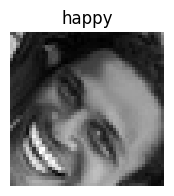

In [ ]:
def show_image(X, y, index = 0):
    emotions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
    plt.figure(figsize = (2,2))
    plt.imshow(X[index], cmap = 'gray')
    plt.title(emotions[y[index]])
    plt.axis('off')
    plt.show()
show_image(image_arrays, labels, 9358)

In [ ]:
X = image_arr / 255.0
y = labels

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=78)
X_val, X_train = X_train[:1000], X_train[1000:]
y_val, y_train = y_train[:1000], y_train[1000:]

In [ ]:
# Define Convolutional Network (CNN)
cnn = Sequential([
    layers.Input(shape=(48, 48, 1)),

    layers.Conv2D(
        filters=64,
        kernel_size=(5,5),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_1'
    ),
    layers.BatchNormalization(name='batchnorm_1'),
    layers.Conv2D(
        filters=64,
        kernel_size=(5,5),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_2'
    ),
    layers.BatchNormalization(name='batchnorm_2'),
    layers.MaxPooling2D(pool_size=(2,2), name='maxpooling1'),
    layers.Dropout(0.4, name='dropout_1'),
    layers.Conv2D(
        filters=128,
        kernel_size=(5,5),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_3'
    ),
    layers.BatchNormalization(name='batchnorm_3'),
    layers.Conv2D(
        filters=128,
        kernel_size=(5,5),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_4'
    ),
    layers.BatchNormalization(name='batchnorm_4'),
    layers.MaxPooling2D(pool_size=(2,2), name='maxpooling2'),
    layers.Dropout(0.4, name='dropout_2'),

    layers.Conv2D(
        filters=128,
        kernel_size=(5,5),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_5'  # Changed layer name from 'conv2d_4' to 'conv2d_5'
    ),
    layers.BatchNormalization(name='batchnorm_5'),
    layers.Dropout(0.4, name='dropout_3'),
])

# Create the final model
model = Sequential([
    cnn,
    layers.Flatten(name='flatten'),
    layers.Dense(128, activation='relu', name='dense_1'),
    layers.Dense(7, activation='softmax', name='output_layer')
])
model.build(input_shape=(None, 48, 48, 1))
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 12, 12, 128)       1130560   
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense_1 (Dense)             (None, 128)               2359424   
                                                                 
 output_layer (Dense)        (None, 7)                 903       
                                                                 
Total params: 3490887 (13.32 MB)
Trainable params: 3489863 (13.31 MB)
Non-trainable params: 1024 (4.00 KB)
_________________________________________________________________


In [ ]:
# Define the residual block
def residual_block(x, filters, kernel_size=3, stride=1, use_batchnorm=True):
    shortcut = x
    if stride != 1 or x.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, (1, 1), strides=stride, padding='same')(shortcut)
        if use_batchnorm:
            shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    if use_batchnorm:
        x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    if use_batchnorm:
        x = layers.BatchNormalization()(x)

    x = layers.add([x, shortcut])
    x = layers.ReLU()(x)
    return x

# Define the ResNet model
def create_resnet_model(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)

    x = layers.Conv2D(64, (7, 7), strides=2, padding='same', activation='relu')(inputs)
    x = layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)

    x = residual_block(x, 64)
    x = residual_block(x, 64)
    x = residual_block(x, 64)

    x = residual_block(x, 128, stride=2)
    x = residual_block(x, 128)
    x = residual_block(x, 128)
    x = residual_block(x, 128)

    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

# Create the ResNet model
input_shape = (48, 48, 1)
num_classes = 7

resnet_model = create_resnet_model(input_shape, num_classes)
resnet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 48, 48, 1)]          0         []                            
                                                                                                  
 conv2d_32 (Conv2D)          (None, 24, 24, 64)           3200      ['input_3[0][0]']             
                                                                                                  
 max_pooling2d_2 (MaxPoolin  (None, 12, 12, 64)           0         ['conv2d_32[0][0]']           
 g2D)                                                                                             
                                                                                                  
 conv2d_33 (Conv2D)          (None, 12, 12, 64)           36928     ['max_pooling2d_2[0][0]'

In [ ]:
# Compile the model
optimizer = SGD(learning_rate=0.01)
resnet_model.compile(
    optimizer=optimizer,
    metrics=['accuracy'],
    loss="sparse_categorical_crossentropy"
)

In [ ]:
x_train = np.array(X_train).reshape(-1, 48, 48, 1)
x_test = np.array(X_test).reshape(-1, 48, 48, 1)
x_val = np.array(X_val).reshape(-1, 48, 48, 1)

# Create a dataset from your NumPy arrays
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# Define batch size and shuffle buffer size
batch_size = 12
shuffle_buffer_size = len(x_train)

# Shuffle and batch the datasets
train_dataset = train_dataset.shuffle(shuffle_buffer_size).batch(batch_size)
validation_dataset = validation_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True
)

In [ ]:
resnet_model.fit(train_dataset, epochs=100, validation_data=validation_dataset, callbacks=[early_stopping])

Epoch 1/100
1592/1592 [==============================] - 19s 12ms/step - loss: 0.6732 - accuracy: 0.7518 - val_loss: 2.2071 - val_accuracy: 0.4390
Epoch 2/100
1592/1592 [==============================] - 19s 12ms/step - loss: 0.6038 - accuracy: 0.7835 - val_loss: 2.8365 - val_accuracy: 0.4020
Epoch 3/100
1592/1592 [==============================] - 19s 12ms/step - loss: 0.5238 - accuracy: 0.8113 - val_loss: 2.7156 - val_accuracy: 0.3750
Epoch 4/100
1592/1592 [==============================] - 19s 12ms/step - loss: 0.4752 - accuracy: 0.8280 - val_loss: 3.1753 - val_accuracy: 0.3930
Epoch 5/100
1592/1592 [==============================] - 19s 12ms/step - loss: 0.4186 - accuracy: 0.8509 - val_loss: 2.6356 - val_accuracy: 0.4670
Epoch 6/100
1592/1592 [==============================] - 19s 12ms/step - loss: 0.3696 - accuracy: 0.8702 - val_loss: 2.4016 - val_accuracy: 0.4180
Epoch 7/100
1592/1592 [==============================] - 19s 12ms/step - loss: 0.3233 - accuracy: 0.8845 - val_loss: 2

In [ ]:
resnet_model.evaluate(train_dataset)

1592/1592 [==============================] - 22s 14ms/step - loss: 0.9217 - accuracy: 0.6629


[0.9217221140861511, 0.6629136800765991]

In [ ]:
resnet_model.evaluate(test_dataset)

718/718 [==============================] - 3s 4ms/step - loss: 1.5168 - accuracy: 0.4756


[1.5167646408081055, 0.47556018829345703]